In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display
import striplog
from striplog.markov import Markov_chain
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [17]:
os.chdir("/Users/euan-soutter/Desktop/Python/Field_Data/Azerbaijan/Data") # Sets working directory
df = pd.read_csv("az_beds.csv",encoding = 'unicode_escape') # Loads data from working directory and assigns name 'df'
df.head() # Displays top 5 rows of df

,Bed_Number,beds_1A,gsize_1A,facies_1A,lith_1A,amal_1A,beds_1B,gsize_1B,facies_1B,lith_1B,...,beds_13A,gsize_13A,facies_13A,lith_13A,amal_13A,beds_13B,gsize_13B,facies_13B,lith_13B,amal_13B
0,1,25.0,2.0,1.0,1.0,1.0,39.0,2.0,1.0,1.0,...,16.0,5.0,4.0,1.0,1.0,73.0,8.0,7.0,2.0,1.0
1,2,8.0,2.0,1.0,1.0,1.0,80.0,5.0,5.0,1.0,...,18.0,6.0,2.0,2.0,1.0,92.0,8.0,7.0,2.0,1.0
2,3,24.0,3.0,4.0,1.0,0.0,24.0,4.0,4.0,1.0,...,267.0,8.0,7.0,2.0,NaN,70.0,6.0,5.0,2.0,1.0
3,4,8.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,135.0,8.0,7.0,2.0,1.0
4,5,15.0,3.0,4.0,1.0,1.0,10.0,2.0,1.0,1.0,...,5.0,6.0,3.0,2.0,NaN,65.0,8.0,7.0,2.0,1.0


In [18]:
df.facies_11A.unique() # Displays facies on log 

array([ 6.,  1.,  3.,  4.,  5., nan])

In [19]:
# Converts df to Markov friendly string
def v2s(df):
    df = df
    df = df[~np.isnan(df)]
    df = ["%.0f" % df for df in df]
    df = ''.join(map(str,df))
    return df

# Assigns data
df4A = v2s(df.facies_4A.values)
df3A = v2s(df.facies_3A.values)

In [29]:
# Makes transition matrix for unique states (facies)
m4A = Markov_chain.from_sequence(df4A, states=['1','2','3','4','5','6','7'],include_self=False)
m3A = Markov_chain.from_sequence(df3A, states=['1','2','3','4','6','7'],include_self=False)

Markov_chain(257 transitions, states=['1', '2', '3', '4', '5', '6', '7'], step=1)


In [21]:
# If chi2 > crit then facies are ordered
print(m4A.chi_squared())
print(m3A.chi_squared())

Chi2(chi2=85.2368355862597, crit=42.55696780429269, perc=0.9999998066668199)
Chi2(chi2=89.02072697245377, crit=30.14352720564616, perc=0.9999999999505607)


In [22]:
# Predicts next 10 facies for each log
print(m3A.generate_states(n=10))
print(m4A.generate_states(n=10))

['1', '3', '1', '3', '6', '1', '3', '1', '4', '1']
['4', '1', '3', '4', '1', '4', '1', '4', '1', '4']


Text(0.48, 0.69, 'Normalised Difference Matrix\n(higher z-transition = more anomalous transition)')

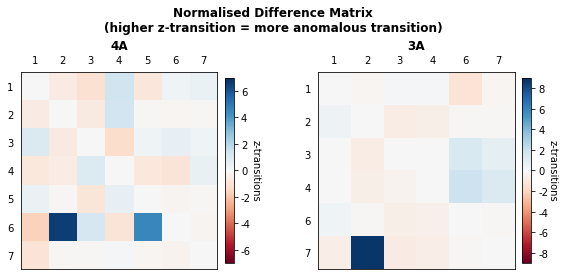

In [27]:
# Plots normalised difference matrix, which shows the facies transitions that skew the data

def plot_norm_diff(self, ax, cmap='RdBu', center_zero=True):

        ax=ax
        
        ma = np.ceil(np.max(self.normalized_difference))
        if center_zero:
            vmin, vmax = -ma, ma
        else:
            vmin, vmax = None, None
       
        ticks = (np.arange(-10,10,2))
        
        ticklabels = np.arange(-10,10,2)
        
        im = ax.imshow(self.normalized_difference, cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax, orientation='vertical',ticks = ticks,shrink=0.22,pad=0.03)
        cbar.ax.set_ylabel('z-transitions', rotation=270,labelpad = 10)
        cbar.ax.set_yticklabels(ticklabels)
        
        ax.tick_params(axis='x', which='both',
                       bottom=False, labelbottom=False,
                       top=False, labeltop=True,)
        ax.tick_params(axis='y', which='both',
                       left=False, labelleft=True,
                       right=False, labelright=False,)
        
        ticks = np.arange(self.states.size)
        ax.set_yticks(ticks)
        ax.set_xticks(ticks)

        labels = [str(s) for s in self.states]
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        # Deal with probable bug in matplotlib 3.1.1
        ax.set_ylim(reversed(ax.get_xlim()))

fig, axs = plt.subplots(ncols=2,figsize=(8,12))

ax=axs[0]
plot_norm_diff(m4A,ax=axs[0])
ax.set_title('4A', fontweight='bold')

ax=axs[1]
plot_norm_diff(m3A,ax=axs[1])
ax.set_title('3A', fontweight='bold')

plt.tight_layout(w_pad=4)
plt.suptitle('Normalised Difference Matrix\n(higher z-transition = more anomalous transition)', fontweight='bold', y=0.69, x=0.48)

m4A.plot_norm_diff

Text(0.5, 1.05, 'Directed Facies Transitions')

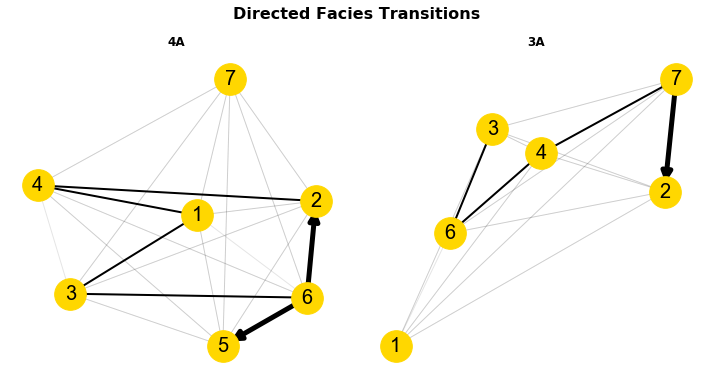

In [33]:
# Plots directed graph of facies transitions 
# Thicker arrow equals more likely transition (but needs to be checked against transitions from cell above)

def plot_graph(self, ax=None,
                   figsize=None,
                   max_size=1000,
                   directed=True,
                   edge_labels=False,
                   draw_neg=False
                   ):
        if self.normalized_difference.ndim > 2:
            raise MarkovError("You can only graph one-step chains.")

        try:
            import networkx as nx
        except ImportError:
            nx = None

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = self.as_graph(directed=directed)
        
        e_neg   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] <= -1.0}
        e_small = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if -1.0 < d['weight'] <=  1.0}
        e_med   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if  1.0 < d['weight'] <=  2.0}
        e_large = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] >   2.0}

        pos = nx.spring_layout(G)

        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1000, node_color='gold',zorder=0)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_large, width=5, arrowsize=20, splines='curved')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_med, width=2, arrowsize=10)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_small,
                               width=1,
                               alpha=0.1,
                               edge_color='k')

        if draw_neg:
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_neg,
                                   width=2,
                                   alpha=0.1,
                                   edge_color='w')

        if edge_labels:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_large)
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_med)

        labels = nx.get_node_attributes(G, 'state')
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax,
                                     font_size=20,
                                     font_family='arial',
                                     font_color='k')

fig, axs = plt.subplots(ncols=2,figsize=(10,5))

ax=axs[0]
plot_graph(m4A,ax=axs[0])
ax.axis('off')
ax.set_title('4A',fontweight='bold')

ax=axs[1]
plot_graph(m3A,ax=axs[1])
ax.axis('off')
ax.set_title('3A', fontweight='bold')

plt.tight_layout(w_pad=2)
plt.suptitle('Directed Facies Transitions', fontweight='bold', y=1.05, x=0.5, fontsize=16)

In [25]:

# *****   SOURCE DATA   *****

"""
Markov chains for the striplog package.
"""
from collections import namedtuple

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from .utils import hollow_matrix


class MarkovError(Exception):
    pass


def regularize(sequence, strings_are_states=False) -> tuple:
    """
    Turn a sequence or sequence of sequences into a tuple of
    the unique elements in the sequence(s), plus a sequence
    of sequences (sort of equivalent to `np.atleast_2d()`).
    Args
        sequence (list-like): A list-like container of either
            states, or of list-likes of states.
        strings_are_states (bool): True if the strings are
            themselves states (i.e. words or tokens) and not
            sequences of one-character states. For example,
            set to True if you provide something like:
                ['sst', 'mud', 'mud', 'sst', 'lst', 'lst']
    Returns
        tuple. A tuple of the unique states, and a sequence
            of sequences.
    """
    if strings_are_states:
        if isinstance(sequence[0], str):
            seq_of_seqs = [sequence]
        else:
            seq_of_seqs = sequence
    else:
        # Just try to iterate over the contents of the sequence.
        try:
            seq_of_seqs = [list(i) if len(i) > 1 else i for i in sequence]
        except TypeError:
            seq_of_seqs = [list(sequence)]

        # Annoyingly, still have to fix case of single sequence of
        # strings... this seems really hacky.
        if len(seq_of_seqs[0]) == 1:
            seq_of_seqs = [seq_of_seqs]

    # Now we know we have a sequence of sequences.
    uniques = set()
    for seq in seq_of_seqs:
        for i in seq:
            uniques.add(i)

    return np.array(sorted(uniques)), seq_of_seqs


class Markov_chain(object):
    """
    Markov_chain object.
    TODO
    - Integrate into `striplog` or move into own project.
    - Pretty transition matrix printing with state names and row/col sums.
    - Allow self-transitions. See also this:
      https://stackoverflow.com/q/49340520/3381305
    - Hidden Markov model?
    - 'Joint' Markov model... where you have lithology and bioturbation index
      (say). Not sure if this is really a thing, I just made it up.
    - More generally, explore other sequence models, eg LSTM.
    """
    def __init__(self,
                 observed_counts,
                 states=None,
                 step=1,
                 include_self=False
                 ):
        """
        Initialize the MarkovChain instance.
        Args
            observed_counts (ndarray): A 2-D array representing the counts
                of change of state in the Markov Chain.
            states (array-like): An array-like representing the possible states
                of the Markov Chain. Must be in the same order as `observed
                counts`.
            step (int): The maximum step size, default 1.
            include_self (bool): Whether to include self-to-self transitions.
        """
        self.step = step
        self.include_self = include_self
        self.observed_counts = np.atleast_2d(observed_counts)

        if states is not None:
            self.states = np.asarray(states)
        elif self.observed_counts is not None:
            self.states = np.arange(self.observed_counts.shape[0])
        else:
            self.states = None

        self.expected_counts = self._compute_expected()

        return

    def __repr__(self):
        trans = f"Markov_chain({np.sum(self.observed_counts):.0f} transitions"
        states = '[{}]'.format(", ".join("\'{}\'".format(s) for s in self.states))
        return f"{trans}, states={states}, step={self.step})"

    @staticmethod
    def _compute_freqs(C):
        """
        Compute frequencies from counts.
        """
        epsilon = 1e-12
        return (C.T / (epsilon+np.sum(C.T, axis=0))).T

    @staticmethod
    def _stop_iter(a, b, tol=0.01):
        a_small = np.all(np.abs(a[-1] - a[-2]) < tol*a[-1])
        b_small = np.all(np.abs(b[-1] - b[-2]) < tol*b[-1])
        return (a_small and b_small)

    @property
    def _index_dict(self):
        if self.states is None:
            return {}
        return {self.states[index]: index for index in range(len(self.states))}

    @property
    def _state_dict(self):
        if self.states is None:
            return {}
        return {index: self.states[index] for index in range(len(self.states))}

    @property
    def observed_freqs(self):
        return self._compute_freqs(self.observed_counts)

    @property
    def expected_freqs(self):
        return self._compute_freqs(self.expected_counts)

    @property
    def _state_counts(self):
        s = self.observed_counts.copy()
        for axis in range(self.observed_counts.ndim - 2):
            s = np.sum(s, axis=0)

        a = np.sum(s, axis=0)
        b = np.sum(s, axis=1)
        return np.maximum(a, b)

    @property
    def _state_probs(self):
        return self._state_counts / np.sum(self._state_counts)

    @property
    def normalized_difference(self):
        O = self.observed_counts
        E = self.expected_counts
        epsilon = 1e-12
        return (O - E) / np.sqrt(E + epsilon)

    @classmethod
    def from_sequence(cls,
                      sequence,
                      states=None,
                      strings_are_states=False,
                      include_self=False,
                      step=1,
                      ngram=False,
                      ):
        """
        Parse a sequence and make the transition matrix of the specified order.
        **Provide sequence ordered in upwards direction.**
        Args
            sequence (list-like): A list-like, or list-like of list-likes.
                The inner list-likes represent sequences of states.
                For example, can be a string or list of strings, or
                a list or list of lists.
            states (list-like): A list or array of the names of the states.
                If not provided, it will be inferred from the data.
            strings_are_states (bool):  rue if the strings are
                themselves states (i.e. words or tokens) and not
                sequences of one-character states. For example,
                set to True if you provide something like:
                    ['sst', 'mud', 'mud', 'sst', 'lst', 'lst']
            include_self (bool): Whether to include self-to-self
                transitions (default is `False`: do not include them).
            step (integer): The distance to step. Default is 1: use
                the previous state only. If 2, then the previous-but-
                one state is used; but if ngram is true then both
                the previous and the previous-but-one are used (and
                the matrix is commensurately bigger).
            ngram (bool): If True, we compute transitions from n-grams,
                so the matrix will have one row for every combination
                of n states. You will want to set return_states to
                True to see the state n-grams.
            return_states (bool): Whether to return the states.
        TODO:
            - Use `states` to figure out whether 'strings_are_states'.
        """
        uniques, seq_of_seqs = regularize(sequence, strings_are_states=strings_are_states)

        if states is None:
            states = uniques
        else:
            states = np.asarray(states)

        O = np.zeros(tuple(states.size for _ in range(step+1)))
        for seq in seq_of_seqs:
            seq = np.array(seq)
            _, integer_seq = np.where(seq.reshape(-1, 1) == states)
            for idx in zip(*[integer_seq[n:] for n in range(step+1)]):
                O[idx] += 1

        if not include_self:
            O = hollow_matrix(O)

        return cls(observed_counts=np.array(O),
                   states=states,
                   include_self=include_self
                   )

    def _conditional_probs(self, state):
        """
        Conditional probabilities of each state, given a
        current state.
        """
        return self.observed_freqs[self._index_dict[state]]

    def _next_state(self, current_state: str) -> str:
        """
        Returns the state of the random variable at the next time
        instance.
        Args
            current_state (str): The current state of the system.
        Returns
            str. One realization of the next state.
        """
        return np.random.choice(self.states,
                                p=self._conditional_probs(current_state)
                                )

    def generate_states(self, n:int=10, current_state:str=None) -> list:
        """
        Generates the next states of the system.
        Args
            n (int): The number of future states to generate.
            current_state (str): The state of the current random variable.
        Returns
            list. The next n states.
        """
        if current_state is None:
            current_state = np.random.choice(self.states, p=self._state_probs)

        future_states = []
        for _ in range(n):
            next_state = self._next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states

    def _compute_expected(self):
        """
        Try to use Powers & Easterling, fall back on Monte Carlo sampling
        based on the proportions of states in the data.
        """
        try:
            E = self._compute_expected_pe()
        except:
            E = self._compute_expected_mc()

        return E

    def _compute_expected_mc(self, n=100000, verbose=False):
        """
        If we can't use Powers & Easterling's method, and it's possible there's
        a way to extend it to higher dimensions (which we have for step > 1),
        the next best thing might be to use brute force and just compute a lot
        of random sequence transitions, given the observed proportions. If I'm
        not mistaken, this is what P & E's method tries to estimate iteratively.
        """
        seq = np.random.choice(self.states, size=n, p=self._state_probs)

        E = self.from_sequence(seq).observed_counts
        E = np.sum(self.observed_counts) * E / np.sum(E)

        if not self.include_self:
            return hollow_matrix(E)
        else:
            return E

    def _compute_expected_pe(self, max_iter=100, verbose=False):
        """
        Compute the independent trials matrix, using method of
        Powers & Easterling 1982.
        """
        m = len(self.states)
        M = self.observed_counts
        a, b = [], []

        # Loop 1
        a.append(np.sum(M, axis=1) / (m - 1))
        b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))

        i = 2
        while i < max_iter:

            if verbose:
                print(f"iteration: {i-1}")
                print(f"a: {a[-1]}")
                print(f"b: {b[-1]}")
                print()

            a.append(np.sum(M, axis=1) / (np.sum(b[-1]) - b[-1]))
            b.append(np.sum(M, axis=0) / (np.sum(a[-1]) - a[-1]))

            # Check for stopping criterion.
            if self._stop_iter(a, b, tol=0.001):
                break

            i += 1

        E = a[-1] * b[-1].reshape(-1, 1)

        if not self.include_self:
            return hollow_matrix(E)
        else:
            return E

    @property
    def degrees_of_freedom(self) -> int:
        m = len(self.states)
        return (m - 1)**2 - m

    def _chi_squared_critical(self, q=0.95, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.ppf(q=q, df=df)

    def _chi_squared_percentile(self, x, df=None):
        """
        The chi-squared critical value for a confidence level q
        and degrees of freedom df.
        """
        if df is None:
            df = self.degrees_of_freedom
        return scipy.stats.chi2.cdf(x, df=df)

    def chi_squared(self, q=0.95):
        """
        The chi-squared statistic for the given transition
        frequencies.
        Also returns the critical statistic at the given confidence
        level q (default 95%).
        If the first number is bigger than the second number,
        then you can reject the hypothesis that the sequence
        is randomly ordered.
        """
        # Observed and Expected matrices:
        O = self.observed_counts
        E = self.expected_counts

        # Adjustment for divide-by-zero
        epsilon = 1e-12
        chi2 = np.sum((O - E)**2 / (E + epsilon))
        crit = self._chi_squared_critical(q=q)
        perc = self._chi_squared_percentile(x=chi2)
        Chi2 = namedtuple('Chi2', ['chi2', 'crit', 'perc'])

        return Chi2(chi2, crit, perc)

    def as_graph(self, directed=True):

        if self.normalized_difference.ndim > 2:
            raise MarkovError("You can only graph one-step chains.")

        try:
            import networkx as nx
        except ImportError:
            nx = None

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        if directed:
            alg = nx.DiGraph
        else:
            alg = nx.Graph

        G = nx.from_numpy_array(self.normalized_difference, create_using=alg)
        nx.set_node_attributes(G, self._state_dict, 'state')
        return G

    def plot_graph(self, ax=None,
                   figsize=None,
                   max_size=1000,
                   directed=True,
                   edge_labels=False,
                   draw_neg=False
                   ):
        if self.normalized_difference.ndim > 2:
            raise MarkovError("You can only graph one-step chains.")

        try:
            import networkx as nx
        except ImportError:
            nx = None

        if nx is None:
            print("Please install networkx with `pip install networkx`.")
            return

        G = self.as_graph(directed=directed)

        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            return_ax = False

        e_neg   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] <= -1.0}
        e_small = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if -1.0 < d['weight'] <=  1.0}
        e_med   = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if  1.0 < d['weight'] <=  2.0}
        e_large = {(u, v):round(d['weight'],1) for (u, v, d) in G.edges(data=True) if        d['weight'] >   2.0}

        pos = nx.spring_layout(G)

        sizes = max_size * (self._state_counts / max(self._state_counts))
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color='orange')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_large, width=10, arrowsize=40, splines='curved')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_med, width=4, arrowsize=20)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_small,
                               width=3,
                               alpha=0.1,
                               edge_color='k')
        if draw_neg:
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=e_neg,
                                   width=2,
                                   alpha=0.1,
                                   edge_color='k')

        if edge_labels:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_large)
            nx.draw_networkx_edge_labels(G,pos,edge_labels=e_med)

        labels = nx.get_node_attributes(G, 'state')
        ax = nx.draw_networkx_labels(G, pos, labels=labels,
                                     font_size=20,
                                     font_family='sans-serif',
                                     font_color='blue')

        if return_ax:
            return ax
        else:
            plt.axis('off')
            plt.show()
            return

    def plot_norm_diff(self, ax=None, cmap='RdBu', center_zero=True):

        if self.normalized_difference.ndim > 2:
            raise MarkovError("You can only plot one-step chains.")

        return_ax = True
        if ax is None:
            fig, ax = plt.subplots(figsize=(1 + self.states.size/2, self.states.size/2))
            return_ax = False

        ma = np.ceil(np.max(self.normalized_difference))

        if center_zero:
            vmin, vmax = -ma, ma
        else:
            vmin, vmax = None, None
        im = ax.imshow(self.normalized_difference, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im)

        ax.tick_params(axis='x', which='both',
                       bottom=False, labelbottom=False,
                       top=False, labeltop=True,
                      )

        ax.tick_params(axis='y', which='both',
                       left=False, labelleft=True,
                       right=False, labelright=False,
                      )

        ticks = np.arange(self.states.size)
        ax.set_yticks(ticks)
        ax.set_xticks(ticks)

        labels = [str(s) for s in self.states]
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        # Deal with probable bug in matplotlib 3.1.1
        ax.set_ylim(reversed(ax.get_xlim()))

        if return_ax:
            return ax
        else:
            plt.show()
            return

ModuleNotFoundError: No module named '__main__.utils'; '__main__' is not a package